In [1]:
import numpy as np
import math
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *
from dfo_player import *
from solo_player import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [2]:
np.random.seed(63)

d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_0 = 0.1
epsilon_1 = 1  # Epsilon sensitivity parameters
epsilon_2 = 1

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.1  # Variance of y^k
sigma_y_p2 = 0.1

beta_p1 = sample_sphere(1,d_1)
beta_p2 = sample_sphere(1,d_2)

# s_1 = sample_sphere(epsilon_1,d_1+d_2)  # Performativity parameters
# mu_p1 = s_1[0:d_1]
# gamma_p1 = s_1[d_1:]
# s_2 = sample_sphere(epsilon_2,d_1+d_2)
# mu_p2 = s_2[0:d_2]
# gamma_p2 = s_2[d_2:]

mu_p1 = sample_sphere(epsilon_0,d_1)
gamma_p1 = sample_sphere(epsilon_1,d_2)
mu_p2 = sample_sphere(epsilon_0,d_2)
gamma_p2 = sample_sphere(epsilon_2,d_1)

p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

N1 = 20
N2 = 10

num_rounds_lst = np.logspace(1,5,N2,dtype='int')
# num_rounds_lst = [50, 100, 500, 1000, 5000, 10000, 50000, 100000]
num_alternate_rounds = 1000
num_test = 1000

In [3]:
p1_risks = np.zeros((N1,N2))
p2_risks = np.zeros((N1,N2))
theta_final_p1 = np.zeros((N1,N2,d_1))
theta_final_p2 = np.zeros((N1,N2,d_2))

delta = 1e-0
eta = 1e-1
num_rounds = num_rounds_lst[-1]

for j in range(N1):
    player_one = DFOPlayer(delta,eta)
    player_two = DFOPlayer(delta,eta)
    game_dfo = DecisionDependentGame(player_one, player_two,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func)

    for i in range(num_rounds+1):
        game_dfo.theta_p1 = player_one.perturb_theta()
        game_dfo.theta_p2 = player_two.perturb_theta()

        PR_1_oracle, PR_2_oracle = game_dfo.evaluate_closed_perf_risk()

        game_dfo.theta_p1 = player_one.update_theta(PR_1_oracle)
        game_dfo.theta_p2 = player_two.update_theta(PR_2_oracle)

        if i in num_rounds_lst:
            p1_risks[j,np.where(num_rounds_lst==i)] = PR_1_oracle
            p2_risks[j,np.where(num_rounds_lst==i)] = PR_2_oracle

            theta_final_p1[j,np.where(num_rounds_lst==i)] = game_dfo.theta_p2
            theta_final_p2[j,np.where(num_rounds_lst==i)] = game_dfo.theta_p2

In [4]:
# np.random.seed(63)

p3_risks = np.zeros((N1,N2))
p4_risks = np.zeros((N1,N2))
theta_final_p3 = np.zeros((N1,N2,d_1))
theta_final_p4 = np.zeros((N1,N2,d_2))

for i in range(N1):
    print(i)
    for num_rounds in num_rounds_lst:
#         print(f"num_rounds = {num_rounds}")
        player_three = TwoStagePlayer()
        player_four = TwoStagePlayer()
        game = DecisionDependentGame(player_three, player_four,
                                     p1_data_params, p2_data_params,
                                     p1_data_generating_func, p2_data_generating_func,
                                     num_rounds, num_alternate_rounds, num_test)

        game.run_train()
        game.run_post_train_alternating()

        PR3, PR4 = game.evaluate_closed_perf_risk()
        p3_risks[i,np.where(num_rounds_lst==num_rounds)] = PR3
        p4_risks[i,np.where(num_rounds_lst==num_rounds)] = PR4

        theta_final_p3[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p2
        theta_final_p4[i,np.where(num_rounds_lst==num_rounds)] = game.theta_p2

0
1
2
3


../utils\utils_functions.py:52: RuntimeWarning: overflow encountered in double_scalars
  + (mu_1.T@theta_1 + gamma_1.T@theta_2)**2
../utils\utils_functions.py:54: RuntimeWarning: overflow encountered in matmul
  + theta_1.T@Sigma_1@theta_1)
../utils\utils_functions.py:56: RuntimeWarning: overflow encountered in double_scalars
  + (mu_2.T@theta_2 + gamma_2.T@theta_1)**2
../utils\utils_functions.py:58: RuntimeWarning: overflow encountered in matmul
  + theta_2.T@Sigma_2@theta_2)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [5]:
theta_PO_1, theta_PO_2 = game.solve_nash()
theta_SO_1, theta_SO_2 = game.solve_social_opt()

game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 PO = 0.479	Player 2 PO = 0.159
Player 1 SO = 0.172	Player 2 SO = 0.194


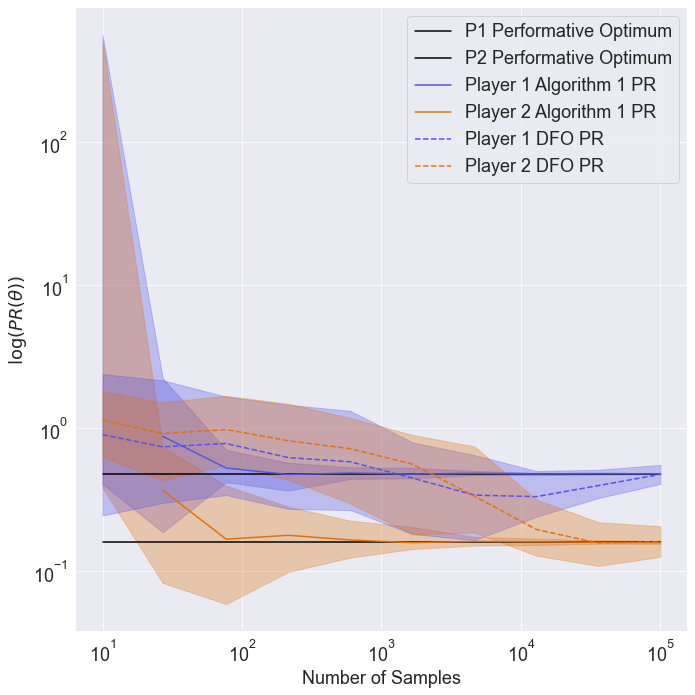

In [12]:
plt.figure(figsize=(10,10))
# plt.subplot(2,1,1)
# plt.semilogx(num_rounds_lst, [PO_1 for i in num_rounds_lst],
#              '-', color='k', label='P1 Performative Optimum')
# plt.semilogx(num_rounds_lst, [PO_2 for i in num_rounds_lst],
#              '-', color='k', label='P2 Performative Optimum') 

# plt.semilogx(num_rounds_lst, p1_risks,
#              '--', color='#5553E6', label='P1 Solo Performative Risk')
# plt.semilogx(num_rounds_lst, p2_risks,
#              '--', color='#E07110', label='P2 2S Performative Risk')

# plt.semilogx(num_rounds_lst, p3_risks,
#              '-', color='#5553E6', label='P1 2S Performative Risk')
# plt.semilogx(num_rounds_lst, p4_risks,
#              '-', color='#E07110', label='P2 2S Performative Risk')
# plt.ylabel(r"$PR(\theta)$")
# plt.legend(fontsize=14)

# plt.subplot(2,1,2)
plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
           '-', color='k', label='P1 Performative Optimum')
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
           '-', color='k', label='P2 Performative Optimum')

# plt.loglog(num_rounds_lst, p1_risks,
#            '--', color='#5553E6', label='P1 Solo Performative Risk')
# plt.loglog(num_rounds_lst, p2_risks,
#            '--', color='#E07110', label='P2 2S Performative Risk')

plt.loglog(num_rounds_lst, np.mean(p3_risks,axis=0),
           '-', color='#5553E6', label='Player 1 Algorithm 1 PR')
plt.fill_between(num_rounds_lst, np.sort(p3_risks,axis=0)[math.floor(N1*0.1)], np.sort(p3_risks,axis=0)[-math.ceil(N1*0.1)], alpha=0.3, color='#5553E6')
plt.loglog(num_rounds_lst, np.mean(p4_risks,axis=0),
           '-', color='#E07110', label='Player 2 Algorithm 1 PR')
plt.fill_between(num_rounds_lst, np.sort(p4_risks,axis=0)[math.floor(N1*0.1)], np.sort(p4_risks,axis=0)[-math.ceil(N1*0.1)], alpha=0.3, color='#E07110')

plt.loglog(num_rounds_lst, np.mean(p1_risks,axis=0),
           '--', color='#5553E6', label='Player 1 DFO PR')
plt.fill_between(num_rounds_lst, np.sort(p1_risks,axis=0)[math.floor(N1*0.1)], np.sort(p1_risks,axis=0)[-math.ceil(N1*0.1)], alpha=0.3, color='#5553E6')
plt.loglog(num_rounds_lst, np.mean(p2_risks,axis=0),
           '--', color='#E07110', label='Player 2 DFO PR')
plt.fill_between(num_rounds_lst, np.sort(p2_risks,axis=0)[math.floor(N1*0.1)], np.sort(p2_risks,axis=0)[-math.ceil(N1*0.1)], alpha=0.3, color='#E07110')

plt.ylabel(r"$\log(PR(\theta))$")
plt.xlabel("Number of Samples")
plt.legend()
plt.savefig('../figures/solo_vs_2stage_convergence.pdf', format='pdf')
plt.tight_layout()
plt.show()

In [7]:
p1_risks

array([[0.85693807, 0.48509929, 0.80930266, 0.31447479, 0.28365067,
        0.26027485, 0.35083929, 0.24799188, 0.37224876, 0.40963037],
       [0.79862582, 0.59584125, 0.59420426, 0.3695302 , 0.39488247,
        0.20216688, 0.18354648, 0.23987119, 0.29550177, 0.4240073 ],
       [2.35940606, 0.99856533, 1.36670473, 1.45590104, 0.86632434,
        0.6615946 , 0.58773858, 0.39331784, 0.32481644, 0.40652369],
       [2.39098928, 2.16044268, 1.65931066, 1.23124085, 1.31858515,
        0.66196055, 0.64747761, 0.46993135, 0.42063258, 0.53998269],
       [0.19940083, 0.29980721, 0.30222404, 0.27731546, 0.26147317,
        0.35822958, 0.33931273, 0.35306621, 0.3433243 , 0.55520688],
       [1.2955073 , 0.73081548, 0.61501072, 0.46423121, 0.67364181,
        0.30323886, 0.21209354, 0.26379555, 0.4701975 , 0.40097273],
       [0.87314394, 0.92171387, 1.21145702, 0.99278925, 1.1026685 ,
        0.79487396, 0.444923  , 0.47066769, 0.4188804 , 0.53102982],
       [0.11369907, 0.09608387, 0.3395040